# Week 14 - Clustering

The following is adapted from K-Means section of **Chapter 9 of Hands-on Machine Learning** book. Please refer to Chapter 9 of the Hands-on Machine Learning book, accessible via the link provided in the course outline.


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/09_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/09_unsupervised_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

# Scikit-Learn ≥ 1.0.1:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


#  define the default font sizes to make the figures prettiers
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/unsupervised_learning` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures.

Although most of the applications of machine learning today are based on supervised learning (and as a result, this is where most of the investments go to), the vast majority of the available data is unlabeled: we have the input features X, but we do not have the labels y. The computer scientist Yann LeCun famously said that “if intelligence was a cake, unsupervised learning would be the cake, supervised learning would be the icing on the cake, and reinforcement learning would be the cherry on the cake.” In other words, there is a huge potential in unsupervised learning that we have only barely started to sink our teeth into.

Say you want to create a system that will take a few pictures of each item on a manufacturing production line and detect which items are defective. You can fairly easily create a system that will take pictures automatically, and this might give you thousands of pictures every day. You can then build a reasonably large dataset in just a few weeks. But wait, there are no labels! If you want to train a regular binary classifier that will predict whether an item is defective or not, you will need to label every single picture as “defective” or “normal”. This will generally require human experts to sit down and manually go through all the pictures. This is a long, costly, and tedious task, so it will usually only be done on a small subset of the available pictures. As a result, the labeled dataset will be quite small, and the classifier’s performance will be disappointing. Moreover, every time the company makes any change to its products, the whole process will need to be started over from scratch. Wouldn’t it be great if the algorithm could just exploit the unlabeled data without needing humans to label every picture? Enter unsupervised learning.

In Chapter 8 we looked at the most common unsupervised learning task: dimensionality reduction. In this chapter we will look at a few more unsupervised tasks:


- Clustering
    - The goal is to group similar instances together into clusters. Clustering is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, and more.

- Anomaly detection (also called outlier detection)
    - The objective is to learn what “normal” data looks like, and then use that to detect abnormal instances. These instances are called anomalies, or outliers, while the normal instances are called inliers. Anomaly detection is useful in a wide variety of applications, such as fraud detection, detecting defective products in manufacturing, identifying new trends in time series, or removing outliers from a dataset before training another model, which can significantly improve the performance of the resulting model.

- Density estimation
    - This is the task of estimating the probability density function (PDF) of the random process that generated the dataset. Density estimation is commonly used for anomaly detection: instances located in very low-density regions are likely to be anomalies. It is also useful for data analysis and visualization.

Ready for some cake? We will start with two clustering algorithms, `k-means` and `DBSCAN`, then we’ll discuss `Gaussian mixture models` and see how they can be used for `density estimation`, `clustering`, and `anomaly detection`.


# Clustering Algorithms: k-means and DBSCAN

As you enjoy a hike in the mountains, you stumble upon a plant you have never seen before. You look around and you notice a few more. They are not identical, yet they are sufficiently similar for you to know that they most likely belong to the same species (or at least the same genus). You may need a botanist to tell you what species that is, but you certainly don’t need an expert to identify groups of similar-looking objects. This is called clustering: it is the task of identifying similar instances and assigning them to clusters, or groups of similar instances.

Just like in classification, each instance gets assigned to a group. However, unlike classification, clustering is an unsupervised task. Consider Figure 9-1: on the left is the iris dataset (introduced in Chapter 4), where each instance’s species (i.e., its class) is represented with a different marker. It is a labeled dataset, for which classification algorithms such as logistic regression, SVMs, or random forest classifiers are well suited. On the right is the same dataset, but without the labels, so you cannot use a classification algorithm anymore. This is where clustering algorithms step in: many of them can easily detect the lower-left cluster. It is also quite easy to see with our own eyes, but it is not so obvious that the upper-right cluster is composed of two distinct subclusters. That said, the dataset has two additional features (sepal length and width) that are not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well (e.g., using a Gaussian mixture model, only 5 instances out of 150 are assigned to the wrong cluster).

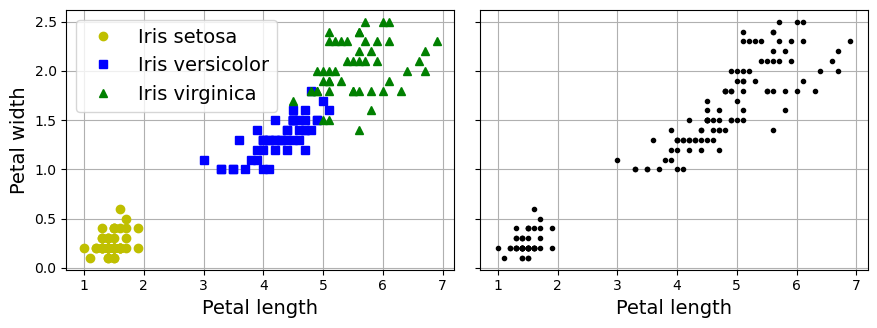

In [3]:
# extra code – this cell generates and saves Figure 9–1

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length")
plt.tick_params(labelleft=False)
plt.gca().set_axisbelow(True)
plt.grid()

save_fig("classification_vs_clustering_plot")
plt.show()

Clustering is used in a wide variety of applications, including:

- Customer segmentation
    - You can cluster your customers based on their purchases and their activity on your website. This is useful to understand who your customers are and what they need, so you can adapt your products and marketing campaigns to each segment. For example, customer segmentation can be useful in recommender systems to suggest content that other users in the same cluster enjoyed.

- Data analysis
    - When you analyze a new dataset, it can be helpful to run a clustering algorithm, and then analyze each cluster separately.

- Dimensionality reduction
    - Once a dataset has been clustered, it is usually possible to measure each instance’s affinity with each cluster; affinity is any measure of how well an instance fits into a cluster. Each instance’s feature vector x can then be replaced with the vector of its cluster affinities. If there are k clusters, then this vector is k-dimensional. The new vector is typically much lower-dimensional than the original feature vector, but it can preserve enough information for further processing.

- Feature engineering
    - The cluster affinities can often be useful as extra features. For example, we used k-means in Chapter 2 to add geographic cluster affinity features to the California housing dataset, and they helped us get better performance.

- Anomaly detection (also called outlier detection)
    - Any instance that has a low affinity to all the clusters is likely to be an anomaly. For example, if you have clustered the users of your website based on their behavior, you can detect users with unusual behavior, such as an unusual number of requests per second.

- Semi-supervised learning
    - If you only have a few labels, you could perform clustering and propagate the labels to all the instances in the same cluster. This technique can greatly increase the number of labels available for a subsequent supervised learning algorithm, and thus improve its performance.

- Search engines
    - Some search engines let you search for images that are similar to a reference image. To build such a system, you would first apply a clustering algorithm to all the images in your database; similar images would end up in the same cluster. Then when a user provides a reference image, all you’d need to do is use the trained clustering model to find this image’s cluster, and you could then simply return all the images from this cluster.

- Image segmentation
    - By clustering pixels according to their color, then replacing each pixel’s color with the mean color of its cluster, it is possible to considerably reduce the number of different colors in an image. Image segmentation is used in many object detection and tracking systems, as it makes it easier to detect the contour of each object.

There is no universal definition of what a cluster is: it really depends on the context, and different algorithms will capture different kinds of clusters. Some algorithms look for instances centered around a particular point, called a centroid. Others look for continuous regions of densely packed instances: these clusters can take on any shape. Some algorithms are hierarchical, looking for clusters of clusters. And the list goes on.

In this section, we will look at two popular clustering algorithms, k-means and DBSCAN, and explore some of their applications, such as nonlinear dimensionality reduction, semi-supervised learning, and anomaly detection.



**Note**: the next cell shows how a Gaussian mixture model (explained later in this chapter) can actually separate these clusters pretty well using all 4 features: petal length & width, and sepal length & width. This code maps each cluster to a class. Instead of hard coding the mapping, the code picks the most common class for each cluster using the `scipy.stats.mode()` function:

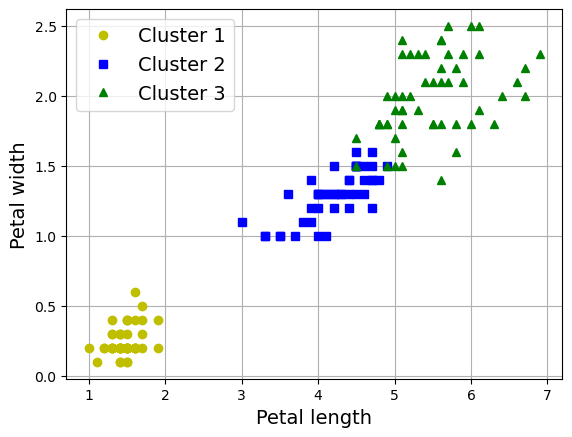

In [4]:
# extra code

import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode] = class_id

y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.grid()
plt.show()

What's the ratio of iris plants we assigned to the right cluster?

In [5]:
(y_pred==y).sum() / len(y_pred)

0.9666666666666667

## K-Means

**Fit and predict**

Let's train a K-Means clusterer on a dataset if blobs. It will try to find each blob's center and assign each instance to the closest blob:

In [6]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# extra code – the exact arguments of make_blobs() are not important
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

Note: Throughout this notebook, when `n_init` was not set when creating a `KMeans` estimator, I explicitly set it to `n_init=10` to avoid a warning about the fact that the default value for this hyperparameter will change from 10 to `"auto"` in Scikit-Learn 1.4.

Now let's plot them:

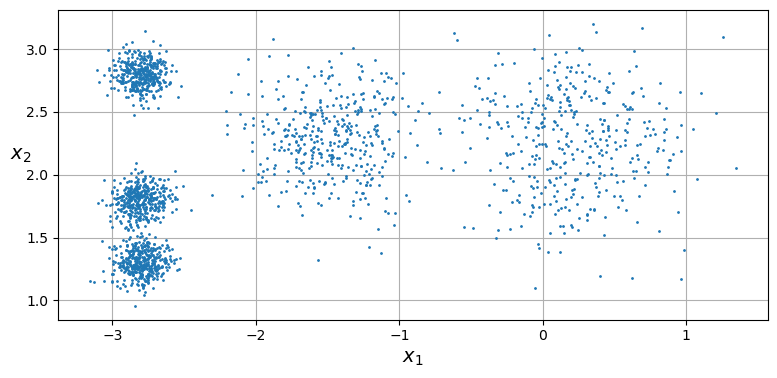

In [7]:
# extra code – this cell generates and saves Figure 9–2

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
save_fig("blobs_plot")
plt.show()

Consider the unlabeled dataset represented in Figure above: you can clearly see five blobs of instances. The k-means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in just a few iterations. It was proposed by Stuart Lloyd at Bell Labs in 1957 as a technique for pulse-code modulation, but it was only published outside of the company in 1982.⁠ In 1965, Edward W. Forgy had published virtually the same algorithm, so k-means is sometimes referred to as the Lloyd–Forgy algorithm.


Note that you have to specify the number of clusters k that the algorithm must find. In this example, it is pretty obvious from looking at the data that k should be set to 5, but in general it is not that easy. We will discuss this shortly.

Each instance will be assigned to one of the five clusters. In the context of clustering, an instance’s label is the index of the cluster to which the algorithm assigns this instance; this is not to be confused with the class labels in classification, which are used as targets (remember that clustering is an unsupervised learning task). The `KMeans` instance preserves the predicted labels of the instances it was trained on, available via the `labels_` instance variable:


Each instance was assigned to one of the 5 clusters:

In [8]:
y_pred

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

In [9]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [10]:
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to (they are not targets, they are predictions):

In [11]:
kmeans.labels_

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

Of course, we can predict the labels of new instances:

In [12]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3], dtype=int32)

**Decision Boundaries**

If you plot the cluster’s decision boundaries, you get a _Voronoi tessellation_: see Figure below, where each centroid is represented with an X:

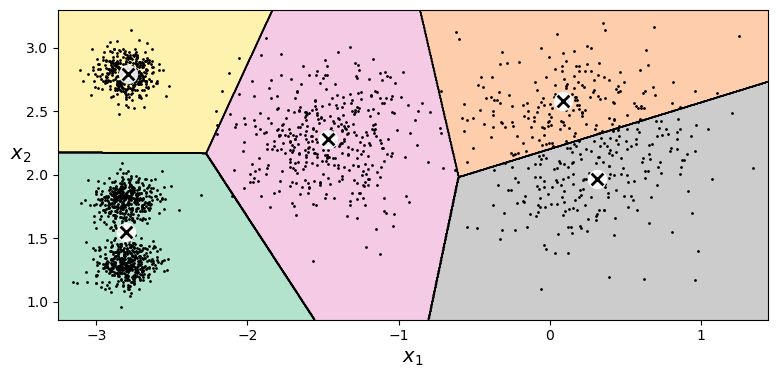

In [13]:
# extra code – this cell generates and saves Figure 9–3

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

The vast majority of the instances were clearly assigned to the appropriate cluster, but a few instances were probably mislabeled, especially near the boundary between the top-left cluster and the central cluster. Indeed, the k-means algorithm does not behave very well when the blobs have very different diameters because all it cares about when assigning an instance to a cluster is the distance to the centroid.



**Hard Clustering _vs_ Soft Clustering**

Instead of assigning each instance to a single cluster, which is called _hard clustering_, it can be useful to give each instance a score per cluster, which is called _soft clustering_. The score can be the distance between the instance and the centroid or a similarity score (or affinity), such as the Gaussian radial basis function we used in Chapter 2. In the KMeans class, the `transform()` method measures the distance from each instance to every centroid:


In [14]:
kmeans.transform(X_new).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [15]:
# extra code
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2)
               - kmeans.cluster_centers_, axis=2).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

In this example, the first instance in `X_new` is located at a distance of about 2.81 from the first centroid, 0.33 from the second centroid, 2.90 from the third centroid, 1.49 from the fourth centroid, and 2.89 from the fifth centroid. If you have a high-dimensional dataset and you transform it this way, you end up with a k-dimensional dataset: this transformation can be a very efficient nonlinear dimensionality reduction technique. Alternatively, you can use these distances as extra features to train another model, as in Chapter 2.

### The K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
* First initialize $k$ centroids randomly: e.g., $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class uses an optimized initialization technique by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"` and `n_init=1`. More on this later in this chapter.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

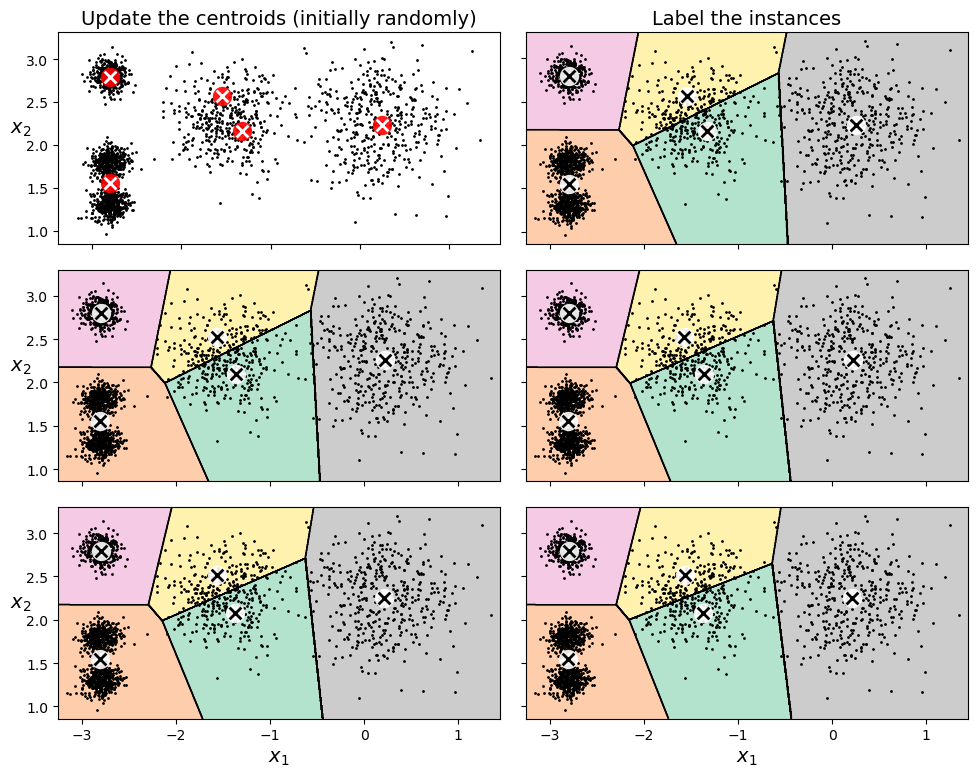

In [16]:
# extra code – this cell generates and saves Figure 9–4

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=5)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=5)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=5)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

---
**NOTE**

The computational complexity of the algorithm is generally linear with regard to the number of instances m, the number of clusters k, and the number of dimensions n. However, this is only true when the data has a clustering structure. If it does not, then in the worst-case scenario the complexity can increase exponentially with the number of instances. In practice, this rarely happens, and k-means is generally one of the fastest clustering algorithms.

---

**K-Means Variability**

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

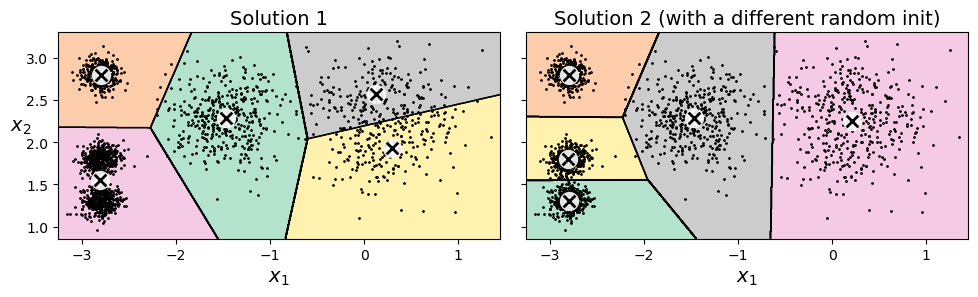

In [17]:
# extra code – this cell generates and saves Figure 9–5

def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=9)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1",
                          "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

Let’s take a look at a few ways you can mitigate this risk by improving the centroid initialization.

### Centroid initialization methods

If you happen to know approximately where the centroids should be (e.g., if you ran another clustering algorithm earlier), then you can set the `init` hyperparameter to a NumPy array containing the list of centroids, and set `n_init` to 1:


In [18]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

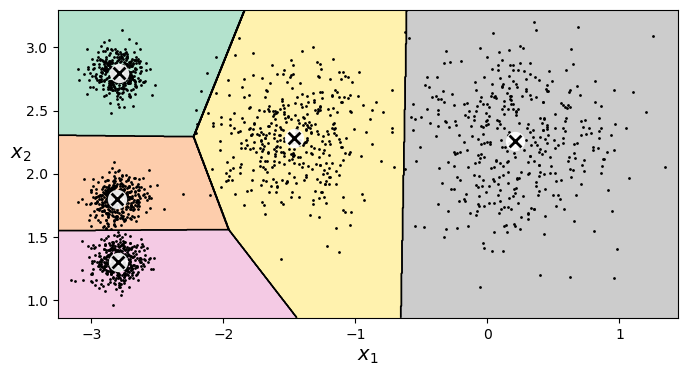

In [19]:
# extra code
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

### Inertia

Another solution is to run the algorithm multiple times with different random initializations and keep the `best` solution. The number of random initializations is controlled by the `n_init` hyperparameter: by default it is equal to 10, which means that the whole algorithm described earlier runs 10 times when you call `fit()`, and Scikit-Learn keeps the best solution. But how exactly does it know which solution is the best? It uses a performance metric! 

That metric is called the model’s `inertia`, which is the sum of the squared distances between the instances and their closest centroids. It is roughly equal to 219.4 for the model on the left in Figure above, 258.6 for the model on the right in Figure above, and only 211.6 for the model in the first KMeans figure. The `KMeans` class runs the algorithm `n_init` times and keeps the model with the lowest inertia. In this example, the model inthe first figure will be selected (unless we are very unlucky with `n_init` consecutive random initializations). If you are curious, a model’s inertia is accessible via the `inertia_` instance variable:

In [20]:
kmeans.inertia_

211.59853725816836

In [21]:
kmeans_rnd_init1.inertia_  # extra code

219.58201503602288

In [22]:
kmeans_rnd_init2.inertia_  # extra code

211.5985372581684

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [23]:
# extra code
X_dist = kmeans.transform(X)
(X_dist[np.arange(len(X_dist)), kmeans.labels_] ** 2).sum()

211.59853725816856

The `score()` method returns the negative inertia (it’s negative because a predictor’s `score()` method must always respect **Scikit-Learn’s “greater is better” rule: if a predictor is better than another, its score() method should return a greater score)**:

In [24]:
kmeans.score(X)

-211.5985372581684

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [25]:
# extra code
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=2)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

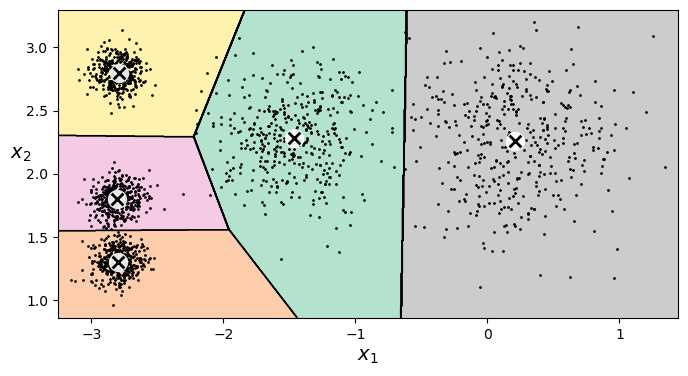

In [26]:
# extra code
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

In [27]:
kmeans_rnd_10_inits.inertia_

211.5985372581684

## Newer KMeans Techniques (Optional)

### Centroid initialization methods

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

### Accelerated K-Means

The K-Means algorithm can sometimes be accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

For Elkan's variant of K-Means, use `algorithm="elkan"`. For regular KMeans, use `algorithm="full"`. The default is `"auto"`, which uses the full algorithm since Scikit-Learn 1.1 (it used Elkan's algorithm before that).

### Mini-Batch K-Means

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)). Instead of using the full dataset at each iteration, the algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm (typically by a factor of three to four) and makes it possible to cluster huge datasets that do not fit in memory. Scikit-Learn implements this algorithm in the `MiniBatchKMeans` class, which you can use just like the KMeans class:

In [28]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)

Note: Throughout this notebook, when `n_init` was not set when creating a `MiniBatchKMeans` estimator, I explicitly set it to `n_init=3` to avoid a warning about the fact that the default value for this hyperparameter will change from 3 to `"auto"` in Scikit-Learn 1.4.

In [29]:
minibatch_kmeans.inertia_

211.65899374574312

**Using `MiniBatchKMeans` along with `memmap`** (not in the book)

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, just like we did for incremental PCA in the previous chapter. First let's load MNIST:

In [30]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")

Let's split the dataset:

In [31]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

Next, let's write the training set to a `memmap`:

In [32]:
filename = "my_mnist.mmap"
X_memmap = np.memmap(filename, dtype='float32', mode='write',
                     shape=X_train.shape)
X_memmap[:] = X_train
X_memmap.flush()

In [33]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10,
                                   n_init=3, random_state=42)
minibatch_kmeans.fit(X_memmap)

MiniBatchKMeans(batch_size=10, n_clusters=10, n_init=3, random_state=42)

Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

100/100

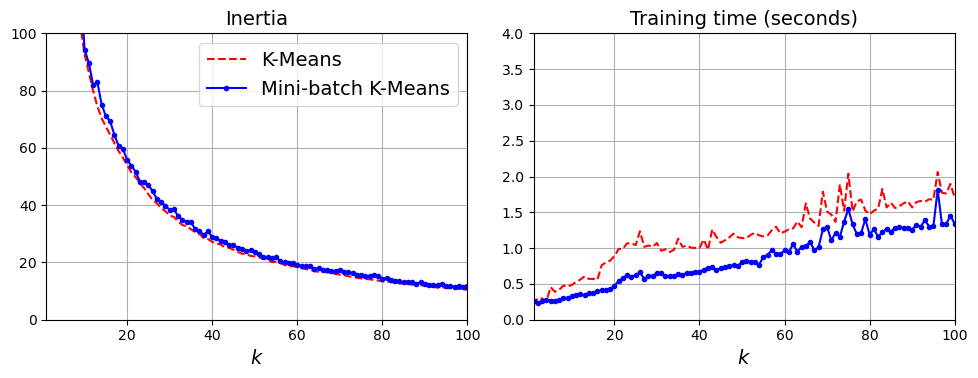

In [34]:
# extra code – this cell generates and saves Figure 9–6

from timeit import timeit

max_k = 100
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))
for k in range(1, max_k + 1):
    kmeans_ = KMeans(n_clusters=k, algorithm="lloyd", n_init=10, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
    print(f"\r{k}/{max_k}", end="")  # \r returns to the start of line
    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10,
                             globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, max_k + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Inertia")
plt.legend()
plt.axis([1, max_k, 0, 100])
plt.grid()

plt.subplot(122)
plt.plot(range(1, max_k + 1), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Training time (seconds)")
plt.axis([1, max_k, 0, 4])
plt.grid()

save_fig("minibatch_kmeans_vs_kmeans_plot")
plt.show()

### Finding the optimal number of clusters

So far, we’ve set the number of clusters k to 5 because it was obvious by looking at the data that this was the correct number of clusters. But in general, it won’t be so easy to know how to set k, and the result might be quite bad if you set it to the wrong value. As you can see in Figure below, for this dataset setting k to 3 or 8 results in fairly bad models.


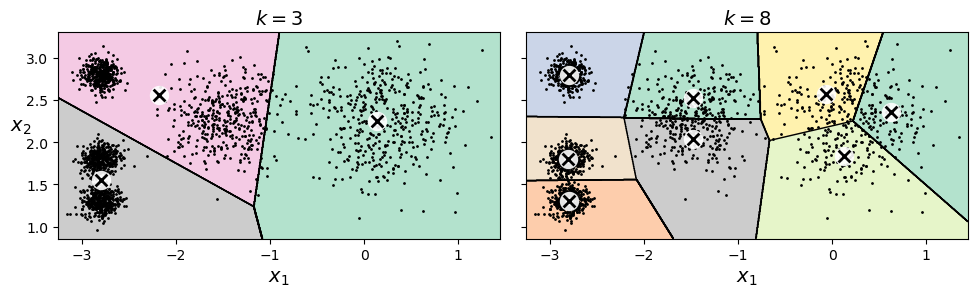

In [35]:
# extra code – this cell generates and saves Figure 9–7

kmeans_k3 = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, n_init=10, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [36]:
kmeans_k3.inertia_

653.2167190021553

In [37]:
kmeans_k8.inertia_

119.22484592677122

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

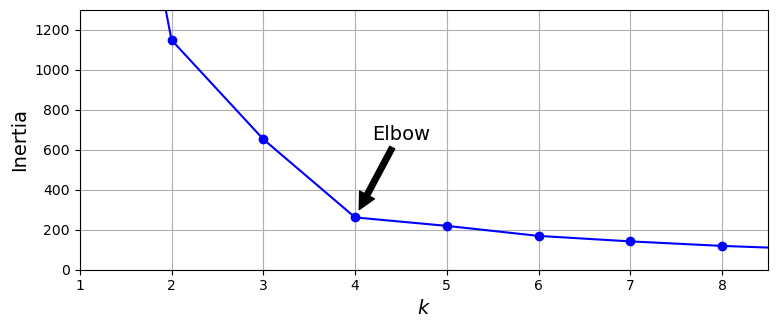

In [38]:
# extra code – this cell generates and saves Figure 9–8

kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
save_fig("inertia_vs_k_plot")
plt.show()

As you can see, the inertia drops very quickly as we increase k up to 4, but then it decreases much more slowly as we keep increasing k. This curve has roughly the shape of an arm, and there is an elbow at k = 4. So, if we did not know better, we might think 4 was a good choice: any lower value would be dramatic, while any higher value would not help much, and we might just be splitting perfectly good clusters in half for no good reason.

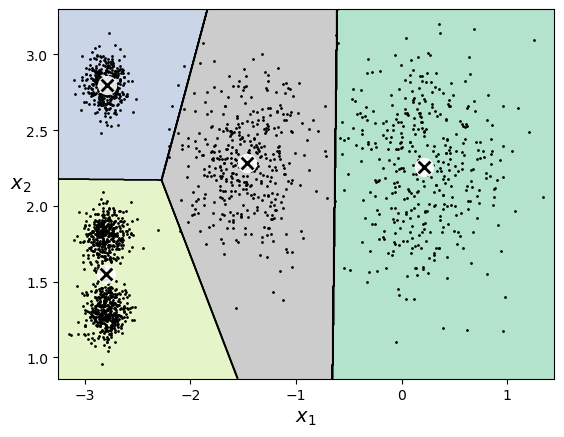

In [39]:
# extra code
plot_decision_boundaries(kmeans_per_k[4 - 1], X)
plt.show()

The previous technique for choosing the best value for the number of clusters is rather coarse. A more precise (but also more computationally expensive) approach is to use the silhouette score, which is the mean silhouette coefficient over all the instances. An instance’s silhouette coefficient is equal to $(b – a) / max(a, b)$, where $a$ is the mean distance to the other instances in the same cluster (i.e., the mean intra-cluster distance) and $b$ is the mean nearest-cluster distance (i.e., the mean distance to the instances of the next closest cluster, defined as the one that minimizes b, excluding the instance’s own cluster). The silhouette coefficient can vary between –1 and +1. A coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary; finally, a coefficient close to –1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [40]:
from sklearn.metrics import silhouette_score

In [41]:
silhouette_score(X, kmeans.labels_)

0.6555176425728279

Let’s compare the silhouette scores for different numbers of clusters.



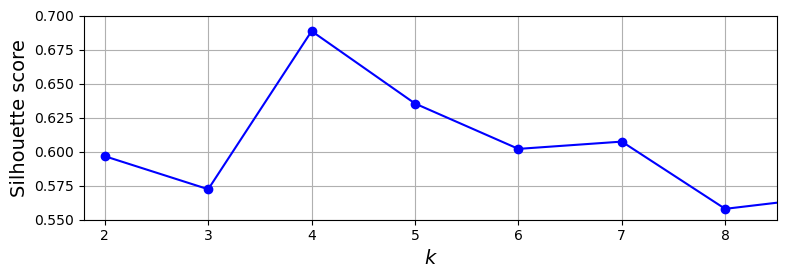

In [42]:
# extra code – this cell generates and saves Figure 9–9

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()
save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one: although it confirms that $k = 4$ is a very good choice, it also highlights the fact that $k = 5$ is quite good as well, and much better than $k = 6$ or $7$. This was not visible when comparing inertias.

An even more informative visualization is obtained when we plot every instance’s silhouette coefficient, sorted by the clusters they are assigned to and by the value of the coefficient. This is called a silhouette diagram (see Figure below). Each diagram contains one knife shape per cluster. The shape’s height indicates the number of instances in the cluster, and its width represents the sorted silhouette coefficients of the instances in the cluster (wider is better).

The vertical dashed lines represent the mean silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. Here we can see that when $k = 3$ or $6$, we get bad clusters. But when $k = 4$ or $5$, the clusters look pretty good: most instances extend beyond the dashed line, to the right and closer to 1.0. When $k = 4$, the cluster at index 1 (the second from the bottom) is rather big. When $k = 5$, all clusters have similar sizes. So, even though the overall silhouette score from $k = 4$ is slightly greater than for $k = 5$, it seems like a good idea to use $k = 5$ to get clusters of similar sizes.

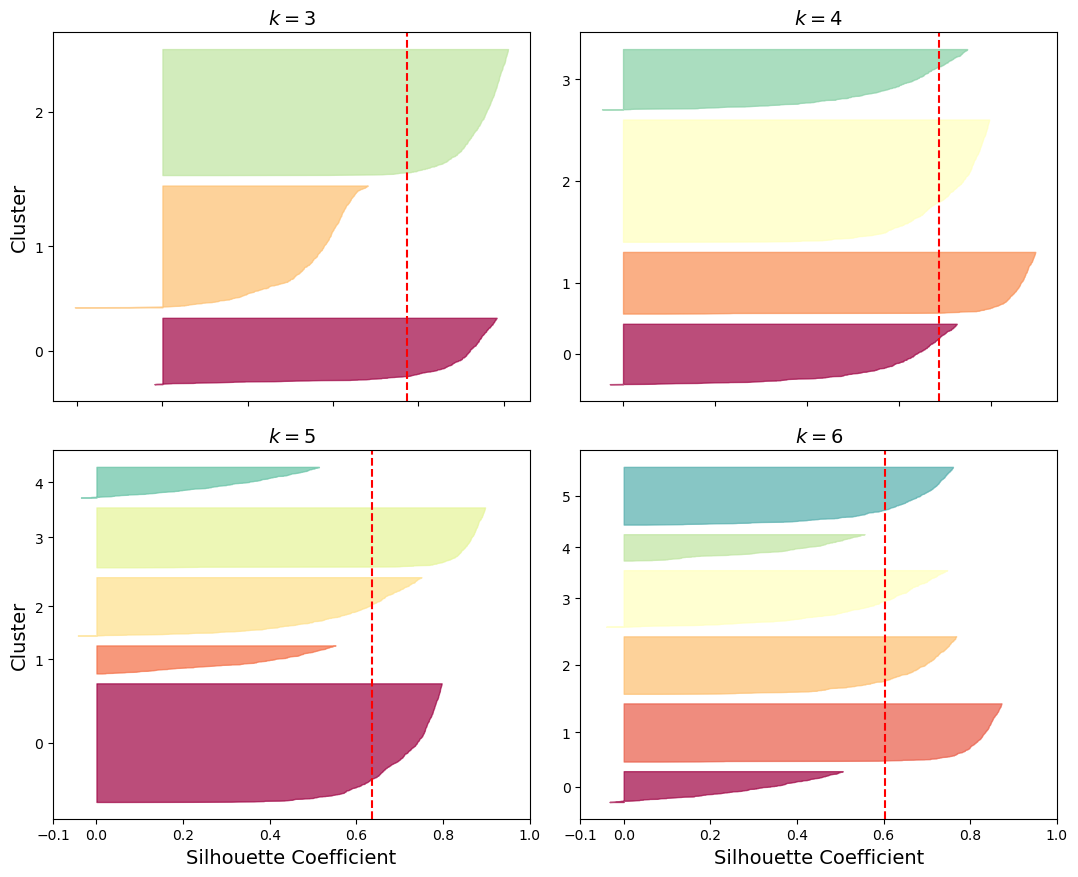

In [43]:
# extra code – this cell generates and saves Figure 9–10

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig("silhouette_analysis_plot")
plt.show()

As you can see, $k=5$ looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

## Limits of K-Means

Despite its many merits, most notably being fast and scalable, k-means is not perfect. As we saw, it is necessary to run the algorithm several times to avoid suboptimal solutions, plus you need to specify the number of clusters, which can be quite a hassle. Moreover, k-means does not behave very well when the clusters have varying sizes, different densities, or nonspherical shapes. For example, Figure below shows how k-means clusters a dataset containing three ellipsoidal clusters of different dimensions, densities, and orientations.

As you can see, neither of these solutions is any good. The solution on the left is better, but it still chops off 25% of the middle cluster and assigns it to the cluster on the right. The solution on the right is just terrible, even though its inertia is lower. So, depending on the data, different clustering algorithms may perform better. On these types of elliptical clusters, `Gaussian mixture models` work great.

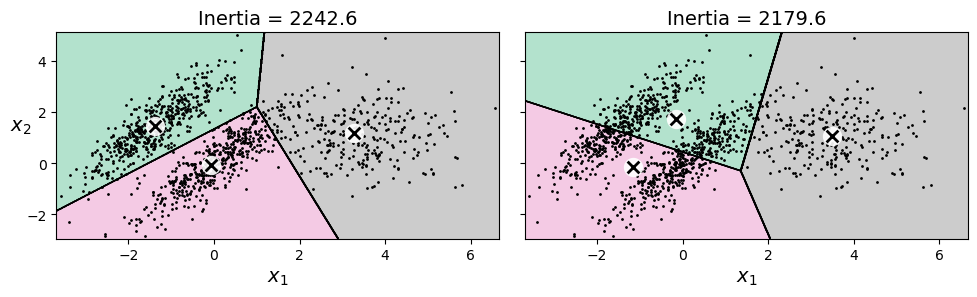

In [44]:
# extra code – this cell generates and saves Figure 9–11
#  Let's generate a more difficult dataset, with elongated blobs and varying densities, 
# and show that K-Means struggles to cluster it correctly:

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

kmeans_good = KMeans(n_clusters=3,
                     init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                     n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title(f"Inertia = {kmeans_good.inertia_:.1f}")

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title(f"Inertia = {kmeans_bad.inertia_:.1f}")

save_fig("bad_kmeans_plot")
plt.show()

---
**TIP**

It is important to scale the input features (see Chapter 2) before you run k-means, or the clusters may be very stretched and k-means will perform poorly. Scaling the features does not guarantee that all the clusters will be nice and spherical, but it generally helps k-means.

---

Now let’s look at a few ways we can benefit from clustering. We will use k-means, but feel free to experiment with other clustering algorithms.

## Using Clustering for Image Segmentation

Image segmentation is the task of partitioning an image into multiple segments. There are several variants:

- In `color segmentation`, pixels with a similar color get assigned to the same segment. This is sufficient in many applications. For example, if you want to analyze satellite images to measure how much total forest area there is in a region, color segmentation may be just fine.

- In `semantic segmentation`, all pixels that are part of the same object type get assigned to the same segment. For example, in a self-driving car’s vision system, all pixels that are part of a pedestrian’s image might be assigned to the “pedestrian” segment (there would be one segment containing all the pedestrians).

- In `instance segmentation`, all pixels that are part of the same individual object are assigned to the same segment. In this case there would be a different segment for each pedestrian.

The state of the art in semantic or instance segmentation today is achieved using complex architectures based on convolutional neural networks (see Chapter 14). In this chapter we are going to focus on the (much simpler) color segmentation task, using k-means.





Download the ladybug image:

In [45]:
# extra code – downloads the ladybug image

import urllib.request

homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
filepath = IMAGES_PATH / filename
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homl3_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

We’ll start by importing the Pillow package (successor to the Python Imaging Library, PIL), which we’ll then use to load the ladybug.png image, assuming it’s located at `filepath`:

In [46]:
import PIL

image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

The image is represented as a 3D array. The first dimension’s size is the height; the second is the width; and the third is the number of color channels, in this case red, green, and blue (RGB). In other words, for each pixel there is a 3D vector containing the intensities of red, green, and blue as unsigned 8-bit integers between 0 and 255. Some images may have fewer channels (such as grayscale images, which only have one), and some images may have more channels (such as images with an additional alpha channel for transparency, or satellite images, which often contain channels for additional light frequencies (like infrared).

The following code reshapes the array to get a long list of RGB colors, then it clusters these colors using k-means with eight clusters. It creates a `segmented_img` array containing the nearest cluster center for each pixel (i.e., the mean color of each pixel’s cluster), and lastly it reshapes this array to the original image shape. The third line uses advanced NumPy indexing; for example, if the first 10 labels in `kmeans_.labels_` are equal to 1, then the first 10 colors in `segmented_img` are equal to `kmeans.cluster_centers_[1]`:

In [47]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, n_init=10, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

This outputs the image shown in the upper right of Figure below. You can experiment with various numbers of clusters, as shown in the figure. When you use fewer than eight clusters, notice that the ladybug’s flashy red color fails to get a cluster of its own: it gets merged with colors from the environment. This is because k-means prefers clusters of similar sizes. The ladybug is small—much smaller than the rest of the image—so even though its color is flashy, k-means fails to dedicate a cluster to it.

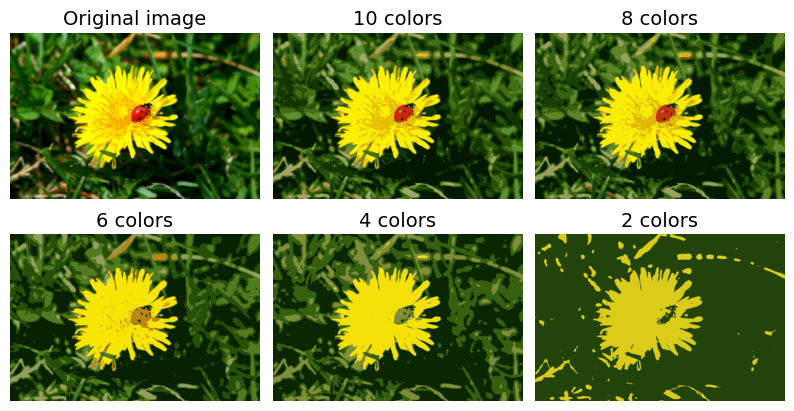

In [48]:
# extra code – this cell generates and saves Figure 9–12
# Image segmentation using k-means with various numbers of color clusters

segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

save_fig('image_segmentation_plot', tight_layout=False)
plt.show()

That wasn’t too hard, was it? Now let’s look at another application of clustering.



## Using Clustering for Semi-Supervised Learning

Another use case for clustering is semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances. In this section, we’ll use the digits dataset, which is a simple MNIST-like dataset containing 1,797 grayscale 8 × 8 images representing the digits 0 to 9. First, let’s load and split the dataset (it’s already shuffled):



In [49]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

We will pretend we only have labels for 50 instances. To get a baseline performance, let’s train a logistic regression model on these 50 labeled instances:

In [50]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

We can then measure the accuracy of this model on the test set (note that the test set must be labeled):

In [51]:
log_reg.score(X_test, y_test)

0.7481108312342569

In [52]:
# extra code – measure the accuracy when we use the whole training set
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.906801007556675

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the `representative images`:

In [53]:
k = 50
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

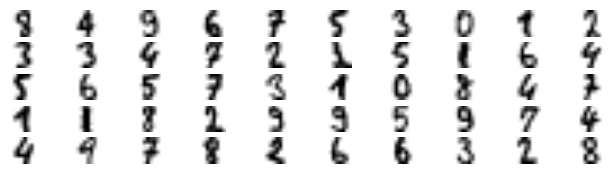

In [54]:
# extra code – this cell generates and saves Figure 9–13

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_plot", tight_layout=False)
plt.show()

Let’s look at each image and manually label them:



In [55]:
y_representative_digits = np.array([
    1, 3, 6, 0, 7, 9, 2, 4, 8, 9,
    5, 4, 7, 1, 2, 6, 1, 2, 5, 1,
    4, 1, 3, 3, 8, 8, 2, 5, 6, 9,
    1, 4, 0, 6, 8, 3, 4, 6, 7, 2,
    4, 1, 0, 7, 5, 1, 9, 9, 3, 7
])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [56]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.06297229219143577

Wow! We jumped from 74.8% accuracy to 84.9%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [57]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [58]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=10000)

Now let’s train the model again and look at its performance:



In [59]:
log_reg.score(X_test, y_test)

0.07808564231738035

We got another significant accuracy boost! Let’s see if we can do even better by ignoring the 1% of instances that are farthest from their cluster center: this should eliminate some outliers. The following code first computes the distance from each instance to its closest cluster center, then for each cluster it sets the 1% largest distances to –1. Lastly, it creates a set without these instances marked with a –1 distance:

In [60]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

Now let’s train the model again on this partially propagated dataset and see what accuracy we get:

In [61]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.07808564231738035

Nice! With just 50 labeled instances (only 5 examples per class on average!) we got 90.9% accuracy, which is actually slightly higher than the performance we got on the fully labeled digits dataset (90.7%). This is partly thanks to the fact that we dropped some outliers, and partly because the propagated labels are actually pretty good—their accuracy is about 97.5%, as the following code shows:

In [62]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

0.09481481481481481

---
**TIP**

Scikit-Learn also offers two classes that can propagate labels automatically: LabelSpreading and LabelPropagation in the sklearn.semi_supervised package. Both classes construct a similarity matrix between all the instances, and iteratively propagate labels from labeled instances to similar unlabeled instances. There’s also a very different class called SelfTrainingClassifier in the same package: you give it a base classifier (such as a RandomForestClassifier) and it trains it on the labeled instances, then uses it to predict labels for the unlabeled samples. It then updates the training set with the labels it is most confident about, and repeats this process of training and labeling until it cannot add labels anymore. These techniques are not magic bullets, but they can occasionally give your model a little boost.

---

---

**ACTIVE LEARNING**

To continue improving your model and your training set, the next step could be to do a few rounds of active learning, which is when a human expert interacts with the learning algorithm, providing labels for specific instances when the algorithm requests them. There are many different strategies for active learning, but one of the most common ones is called `uncertainty sampling`. Here is how it works:

- The model is trained on the labeled instances gathered so far, and this model is used to make predictions on all the unlabeled instances.

- The instances for which the model is most uncertain (i.e., where its estimated probability is lowest) are given to the expert for labeling.

- You iterate this process until the performance improvement stops being worth the labeling effort.

Other active learning strategies include labeling the instances that would result in the largest model change or the largest drop in the model’s validation error, or the instances that different models disagree on (e.g., an SVM and a random forest).